# Deep Dive in Anomaly Detection with Deep Learning
**Cyber Data Science Sharing Session #3**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
import os

### 1) Downloading the dataset

- The data we used is simulated for **Window Event 4624**, which records each logon event. Actually, ADX Data Lake collects data once one logon happened, which means **each row is one event**.  
- However, to catch suspicious attacker, we need to aggregate the ADX data on the user level. 
- Depending on the event characertics or the project objective, the aggregation can be done on the hour level or day level. For this demo, the data is **aggregated on the daily basis**.
- Here, We only take the data for **one user**. Also, only some of the columns are selected for example.

In [2]:
daily_df = pd.read_csv('https://raw.githubusercontent.com/LiuLaki/DataSci-Sharing-Session/main/user_data.csv')
daily_df

,datetime,nb_ip,avg_time_interval,nb_logon,nb_event_categories,nb_domain,nb_fail_logon,nb_programs
0,2009-07-15,0.0,0.0,242.0,2.0,1.0,1.0,4.0
1,2009-07-16,0.0,0.0,242.0,2.0,0.0,1.0,3.0
2,2009-07-17,1.0,0.0,242.0,2.0,0.0,0.0,5.0
3,2009-07-18,1.0,0.0,242.0,3.0,0.0,0.0,4.0
4,2009-07-19,1.0,0.0,242.0,4.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...
495,2010-11-22,1.0,0.0,240.0,6.0,3.0,1.0,7.0
496,2010-11-23,1.0,0.0,241.0,5.0,1.0,0.0,5.0
497,2010-11-24,1.0,0.0,240.0,5.0,1.0,2.0,8.0
498,2010-11-25,1.0,0.0,242.0,4.0,1.0,0.0,4.0


### 2) Data Processing

- Data Cleaning : Deep Learning Neural Network models **only accept numrical data**. All the data in forms of string, text, date time should be transformed into numbers.

In [3]:
daily_df = daily_df.set_index('datetime')
daily_df

,nb_ip,avg_time_interval,nb_logon,nb_event_categories,nb_domain,nb_fail_logon,nb_programs
datetime,,,,,,,
2009-07-15,0.0,0.0,242.0,2.0,1.0,1.0,4.0
2009-07-16,0.0,0.0,242.0,2.0,0.0,1.0,3.0
2009-07-17,1.0,0.0,242.0,2.0,0.0,0.0,5.0
2009-07-18,1.0,0.0,242.0,3.0,0.0,0.0,4.0
2009-07-19,1.0,0.0,242.0,4.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...
2010-11-22,1.0,0.0,240.0,6.0,3.0,1.0,7.0
2010-11-23,1.0,0.0,241.0,5.0,1.0,0.0,5.0
2010-11-24,1.0,0.0,240.0,5.0,1.0,2.0,8.0


#### 2.1 Train Test Split

- We need to split the overall dataset into two parts - train and test. We will use train data to train the Deep Learning models, and use the test dataset to see the performance. **The objective is to make sure the model we trained can be generalised to other dataset**.

In [4]:
# Split Ratio : 75% of Data to train, 25% of Data to test
thres = int(daily_df.shape[0]*0.75)
train_df,test_df = daily_df[1:thres], daily_df[thres:]
train_df.shape,test_df.shape

((374, 7), (125, 7))

#### 2.2 Scaling : MinMax Scaler

- Reasons : Deep Neural Networks are **very sentitive to the number scale**. To minimize the error, we should scale all the data in the specific range by different types of scalers.

In [5]:
train = train_df
scalers={}

for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

/tmp/ipykernel_57076/1434863843.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
/tmp/ipykernel_57076/1434863843.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
/tmp/ipykernel_57076/1434863843.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [6]:
train

,nb_ip,avg_time_interval,nb_logon,nb_event_categories,nb_domain,nb_fail_logon,nb_programs
datetime,,,,,,,
2009-07-16,0.0,0.0,0.545455,0.000000,0.000,0.166667,0.071429
2009-07-17,0.5,0.0,0.545455,0.000000,0.000,0.000000,0.214286
2009-07-18,0.5,0.0,0.545455,0.166667,0.000,0.000000,0.142857
2009-07-19,0.5,0.0,0.545455,0.333333,0.000,0.000000,0.142857
2009-07-20,0.0,0.0,0.545455,0.000000,0.125,0.166667,0.071429
...,...,...,...,...,...,...,...
2010-07-20,0.5,0.0,0.545455,0.166667,0.000,0.000000,0.142857
2010-07-21,0.5,0.0,0.545455,0.166667,0.125,0.000000,0.142857
2010-07-22,0.5,0.0,0.454545,0.333333,0.000,0.166667,0.142857


### 3) LSTM Model Preparation : Sequence Data

- Recall LSTM : **Long Short Term Memory (LSTM)** is one type of **Recurrent Neural Network (RNN)**. For a time series data, LSTM can predict the next occurance by **remembering the previous important information** and **forgetting unimportant information.**

- **Hyperparameters** mean the parameters that are not a part of models - there is no academical way to set, but there are some data science techniques to help find the most optimal one. 

- **Most Import Hyperparameters in LSTM :** the number of sequqnce elements we look back, and the number of sequence elements we are going to predict

In [7]:
# For this case, let's assume that
# Given past 10 days observation, forecast the next 5 days observations. 
n_past = 10
n_future = 5 
n_features = 7

In [8]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [9]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [10]:
X_train[0]

array([[0.        , 0.        , 0.54545455, 0.        , 0.        ,
        0.16666667, 0.07142857],
       [0.5       , 0.        , 0.54545455, 0.        , 0.        ,
        0.        , 0.21428571],
       [0.5       , 0.        , 0.54545455, 0.16666667, 0.        ,
        0.        , 0.14285714],
       [0.5       , 0.        , 0.54545455, 0.33333333, 0.        ,
        0.        , 0.14285714],
       [0.        , 0.        , 0.54545455, 0.        , 0.125     ,
        0.16666667, 0.07142857],
       [0.5       , 0.        , 0.63636364, 0.16666667, 0.        ,
        0.16666667, 0.21428571],
       [0.5       , 0.        , 0.54545455, 0.        , 0.        ,
        0.        , 0.07142857],
       [0.5       , 0.        , 0.54545455, 0.16666667, 0.125     ,
        0.        , 0.28571429],
       [0.        , 0.        , 0.54545455, 0.        , 0.        ,
        0.        , 0.07142857],
       [0.        , 0.        , 0.54545455, 0.        , 0.        ,
        0.        , 0.0

In [11]:
y_train[0]

array([[0.        , 0.        , 0.63636364, 0.        , 0.        ,
        0.16666667, 0.07142857],
       [0.        , 0.        , 0.63636364, 0.        , 0.        ,
        0.16666667, 0.14285714],
       [0.5       , 0.        , 0.54545455, 0.16666667, 0.        ,
        0.5       , 0.07142857],
       [0.5       , 0.        , 0.54545455, 0.16666667, 0.125     ,
        0.16666667, 0.21428571],
       [0.5       , 0.        , 0.54545455, 0.        , 0.        ,
        0.33333333, 0.07142857]])

In [12]:
len(X_train), len(y_train)

(360, 360)

### 4) LSTM Model

#### 4.1 Model Architecture
1. For Deep Learning, **the first step** is to define each layer - which layer to put, and which parameters to set. 

2. **Then** we can train the model : Here we need to define how to train the model - how many epochs, what are the loss functions, what methods to optimize. This process allows the model to learn from the data. By comparing the results predicted by model and the realilty to get the best model.

3. **Last Step** is to use the model we trained, to predict the unknowns. Once We get the results, we can try to interpretate, or post-process them to get the insights.


For this demo, we will train **Two Deep Learning LSTM Models**
- **Model 1 - E1D1** : Sequence to Sequence Model with one encoder layer and one decoder layer. 

- **Model 2 - E2D2** : Sequence to Sequence Model with two encoder layers and two decoder layers. 

In [14]:
[10, 7] * [7, 100]

2022-07-01 14:38:58.316871: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-01 14:39:12.698111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7435 MB memory:  -> device: 0, name: Tesla M60, pci bus id: 0001:00:00.0, compute capability: 5.2


In [13]:
# Model 1 Definition: E1D1

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]


decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,
                                                              initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

##
model_e1d1 = tf.keras.models.Model(encoder_inputs,
                                   decoder_outputs1)

model_e1d1.summary()

2022-07-01 10:10:02.596339: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-01 10:10:15.281526: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7435 MB memory:  -> device: 0, name: Tesla M60, pci bus id: 0001:00:00.0, compute capability: 5.2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 7)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        43200       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 5, 100)       0           ['lstm[0][0]']                   
                                                                                              

In [14]:
# Model 2 Definition: E2D2

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, 
                                  return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]

encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]


decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,
                                                              initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,
                                                              initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)



model_e2d2 = tf.keras.models.Model(encoder_inputs,
                                   decoder_outputs2)
#
model_e2d2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 7)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 10, 100),    43200       ['input_2[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_3 (LSTM)                  [(None, 100),        80400       ['lstm_2[0][0]']                 
                                 (None, 100),                                               

#### 4.2 Training the models


In [15]:
# Define GPU
gpu_strategy = tf.distribute.get_strategy()

with gpu_strategy.scope():
    

    # define learning rate
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

    ######################
    ##### Model 1 ########
    ######################
    # define optimization method
    model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), 
                       loss=tf.keras.losses.Huber())
    
    # define traing method
    history_e1d1=model_e1d1.fit(X_train,
                                y_train,
                                epochs=25,
                                validation_data=(X_test,y_test),
                                batch_size=32,
                                verbose=0,
                                callbacks=[reduce_lr])

    ######################
    ##### Model 2 ########
    ######################
    # define optimization method
    model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), 
                       loss=tf.keras.losses.Huber())
    
     # define traing method
    history_e2d2=model_e2d2.fit(X_train,
                                y_train,
                                epochs=25,
                                validation_data=(X_test,y_test),
                                batch_size=32,
                                verbose=0,
                                callbacks=[reduce_lr])

2022-07-01 10:10:32.606208: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


#### 4.3 Checking Error

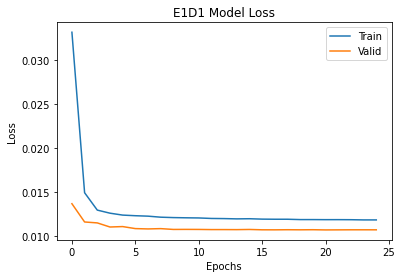

In [16]:
# Error Analysis for Model 1

plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("E1D1 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

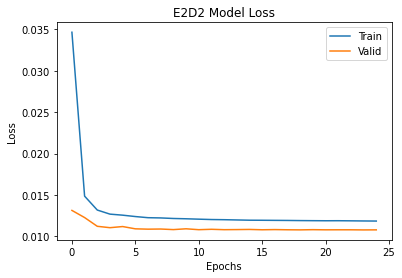

In [17]:
# Error Analysis for Model 2

plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

#### 4.4 Prediction on test set

In [18]:
# Prediction on test set using Model 1

pred_e1d1=model_e1d1.predict(X_train)
pred1_e1d1=model_e1d1.predict(X_test)

pred1_e1d1[0]

array([[ 0.2657032 ,  0.02109489,  0.32228175,  0.10558844,  0.0759377 ,
         0.12833036,  0.14161158],
       [ 0.27345437,  0.00702652,  0.3591442 ,  0.10409012,  0.07548866,
         0.14644086,  0.12828523],
       [ 0.27794605, -0.00264779,  0.37958798,  0.10035673,  0.07390881,
         0.15313771,  0.11601344],
       [ 0.2803792 , -0.00935071,  0.3895485 ,  0.09563474,  0.07207446,
         0.15367903,  0.10541991],
       [ 0.281516  , -0.01398542,  0.39301184,  0.09072449,  0.07033985,
         0.15113805,  0.09664373]], dtype=float32)

In [19]:
len(X_test), len(pred1_e1d1)

(111, 111)

In [20]:
# Prediction on test set using Model 2

pred_e2d2=model_e2d2.predict(X_train)
pred1_e2d2=model_e2d2.predict(X_test)

pred1_e2d2[0]

array([[ 2.79523224e-01, -1.14984484e-02,  3.70163739e-01,
         1.19998299e-01,  8.42699185e-02,  1.18101202e-01,
         1.08208962e-01],
       [ 2.90278822e-01, -8.14231578e-03,  3.77403378e-01,
         1.09127976e-01,  8.37130025e-02,  1.23425938e-01,
         1.09710380e-01],
       [ 2.99795359e-01, -3.92830651e-03,  3.80104423e-01,
         1.01873375e-01,  8.47241208e-02,  1.28427371e-01,
         1.11569688e-01],
       [ 3.07802916e-01,  1.43837184e-04,  3.80036235e-01,
         9.83157679e-02,  8.64914730e-02,  1.32627845e-01,
         1.14523672e-01],
       [ 3.14246923e-01,  3.57580744e-03,  3.78433228e-01,
         9.79799256e-02,  8.84724185e-02,  1.35841385e-01,
         1.18861273e-01]], dtype=float32)

#### 4.5 Inverse Scaling of the predicted values

- Recall that we did the Standard Scaling before. Now we need to inverse the data to its orginial scale

In [83]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    
    pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

#### 4.6 Model Performance Evaluation

In [85]:

for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,6):
    print("Day ",j,":")
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
  print()
  print()
  

nb_ip
Day  1 :
MAE-E1D1 :  3.4538541141122874, MAE-E2D2 :  3.5570016013513697
Day  2 :
MAE-E1D1 :  3.443806186761006, MAE-E2D2 :  3.328872085797905
Day  3 :
MAE-E1D1 :  3.374585578937342, MAE-E2D2 :  3.0911567506223623
Day  4 :
MAE-E1D1 :  3.2393189078510396, MAE-E2D2 :  2.889867132252986
Day  5 :
MAE-E1D1 :  3.044686400064147, MAE-E2D2 :  2.7306607347903866


avg_time_interval
Day  1 :
MAE-E1D1 :  0.07111157354493026, MAE-E2D2 :  0.0741373664229223
Day  2 :
MAE-E1D1 :  0.13826256935106646, MAE-E2D2 :  0.11847214555681342
Day  3 :
MAE-E1D1 :  0.20616657456549087, MAE-E2D2 :  0.13989420456461388
Day  4 :
MAE-E1D1 :  0.2708034630459134, MAE-E2D2 :  0.15028173026472036
Day  5 :
MAE-E1D1 :  0.3495084006007355, MAE-E2D2 :  0.1544444487236514


nb_logon
Day  1 :
MAE-E1D1 :  31801.389351873113, MAE-E2D2 :  31790.423956389473
Day  2 :
MAE-E1D1 :  31799.39628314028, MAE-E2D2 :  31788.878607721614
Day  3 :
MAE-E1D1 :  31795.533209470235, MAE-E2D2 :  31785.48719651628
Day  4 :
MAE-E1D1 :  31795.7

From the above output we can observe that in some cases E2D2 model has 
performed better than E1D1 model with less error. Training different models with different number of stacked layers and creating an ensemble model also performs well. 

Note: The results vary with respect to the dataset. If we stack more layers it may also lead to overfitting. So the no of layers to be stackes acts as a hyper parameter. 